In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy import signal

from filters import AdaptiveEqualizerAlamouti, CDCompensator, PulseFilter
from frequency_recovery import FrequencyRecovery
from modulation import Demodulator16QAM, Modulator16QAM
from receiver import Digital90degHybrid
from utils import normalize_power

In [3]:
def plot_signal(signal: np.ndarray) -> None:
    assert signal.ndim == 1
    assert signal.size > 0

    s_real = np.real(signal[:8192])
    s_imag = np.imag(signal[:8192])

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

    # Constellation diagram.
    ax = axs[0][0]
    ax.scatter(s_real, s_imag, alpha=0.05)
    ax.axis("equal")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(color="black")
    ax.axvline(color="black")

    # Unused plot.
    axs[1][0].set_axis_off()

    # Signal (real component).
    ax = axs[0][1]
    ax.stem(s_real)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("In-phase")

    # Signal (imaginary component).
    ax = axs[1][1]
    ax.stem(s_imag)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Quadrature")

    # Spectrum.
    axs[0][2].magnitude_spectrum(signal.tolist(), sides="twosided")
    axs[1][2].phase_spectrum(signal.tolist(), sides="twosided")

    fig.tight_layout()

    plt.show()

In [4]:
# 256 GSa/s, stored as 16-bit signed integers
data_256i = np.ravel(scipy.io.loadmat("data_alamouti/capture_50G_S_-17.5.mat")["ch1"])

# Convert to cdouble, subtract the DC component, and normalize power
data_256d = data_256i.astype(np.cdouble)
data_256d -= data_256d.mean()
data_256d = normalize_power(data_256d)

# Reference data
# TODO also look at the transmitted data, and compare it with what is produced
# by the simulation
data_ref = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["s_qam"])
data_ref = normalize_power(data_ref)
data_ref.size

32768

In [5]:
sx2 = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["sx2"])
sy2 = np.ravel(scipy.io.loadmat("data_alamouti/AC_data.mat")["sy2"])

In [6]:
qpsk_sync = np.ravel(scipy.io.loadmat("data_alamouti/QPSK_sync.mat")["s"])
qpsk_sync.size

1024

In [7]:
assert np.allclose(sx2[:1024], qpsk_sync)
assert np.allclose(sy2[:1024], qpsk_sync)
assert np.allclose(sx2[1024:2048], qpsk_sync)
assert np.allclose(sy2[1024:2048], qpsk_sync)

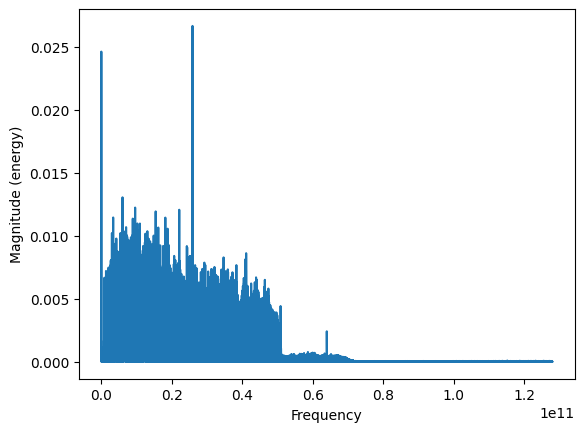

In [8]:
plt.magnitude_spectrum(data_256d.real.tolist(), Fs=256e9);

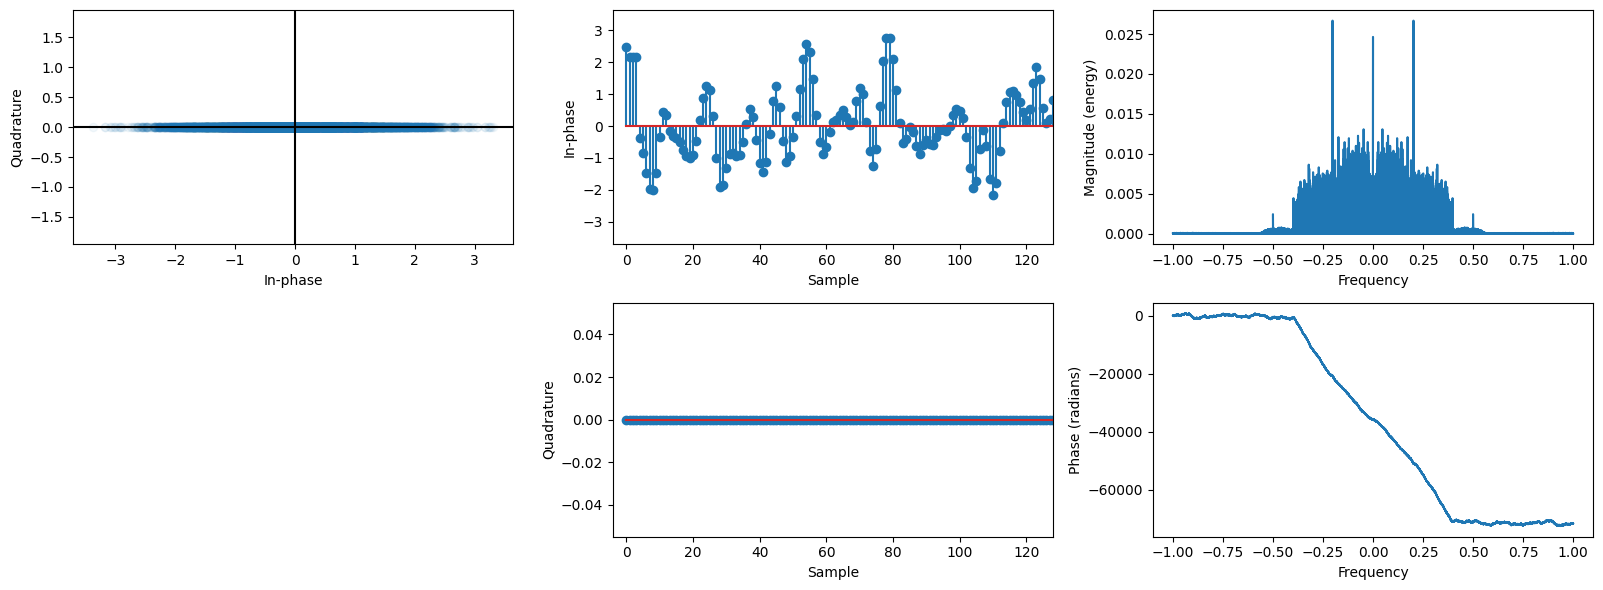

In [9]:
plot_signal(data_256d)

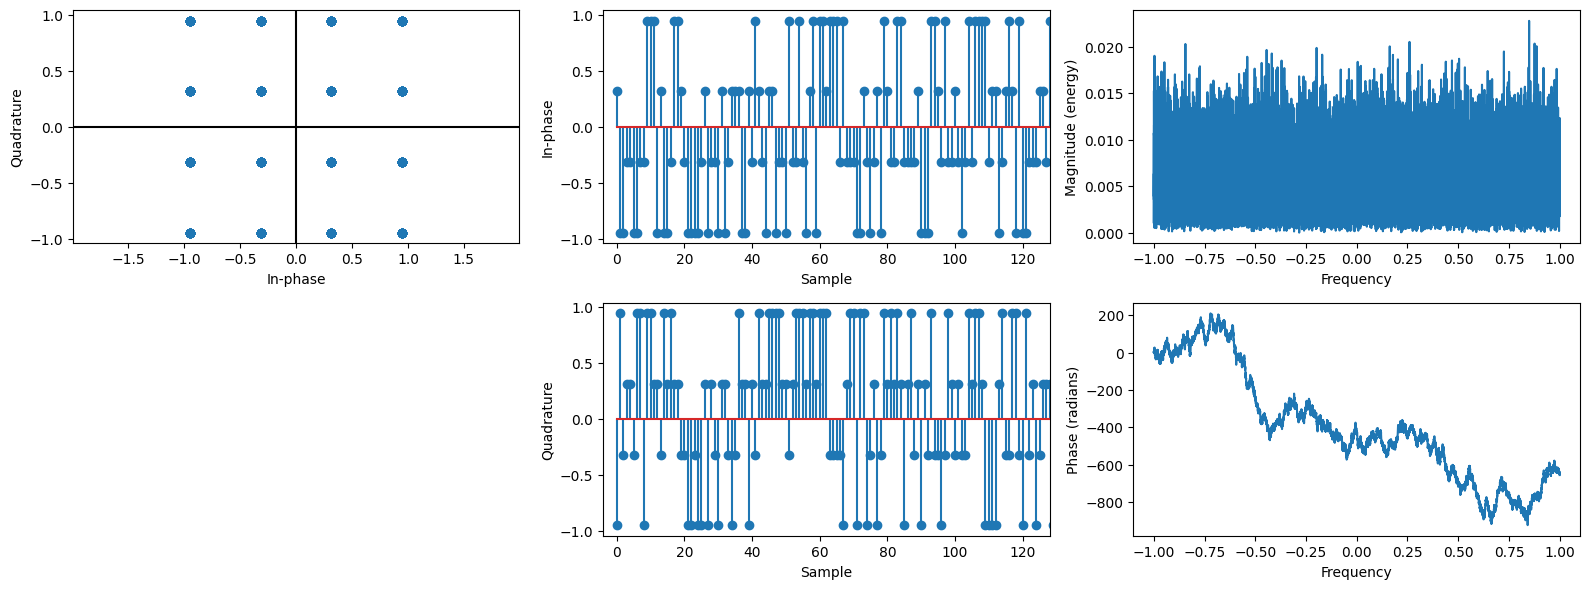

In [10]:
plot_signal(data_ref)

In [11]:
# Resample to 100 GSa/s (2 SpS)
data_100 = scipy.signal.resample_poly(data_256d, up=25, down=64)
data_100.shape

(585938,)

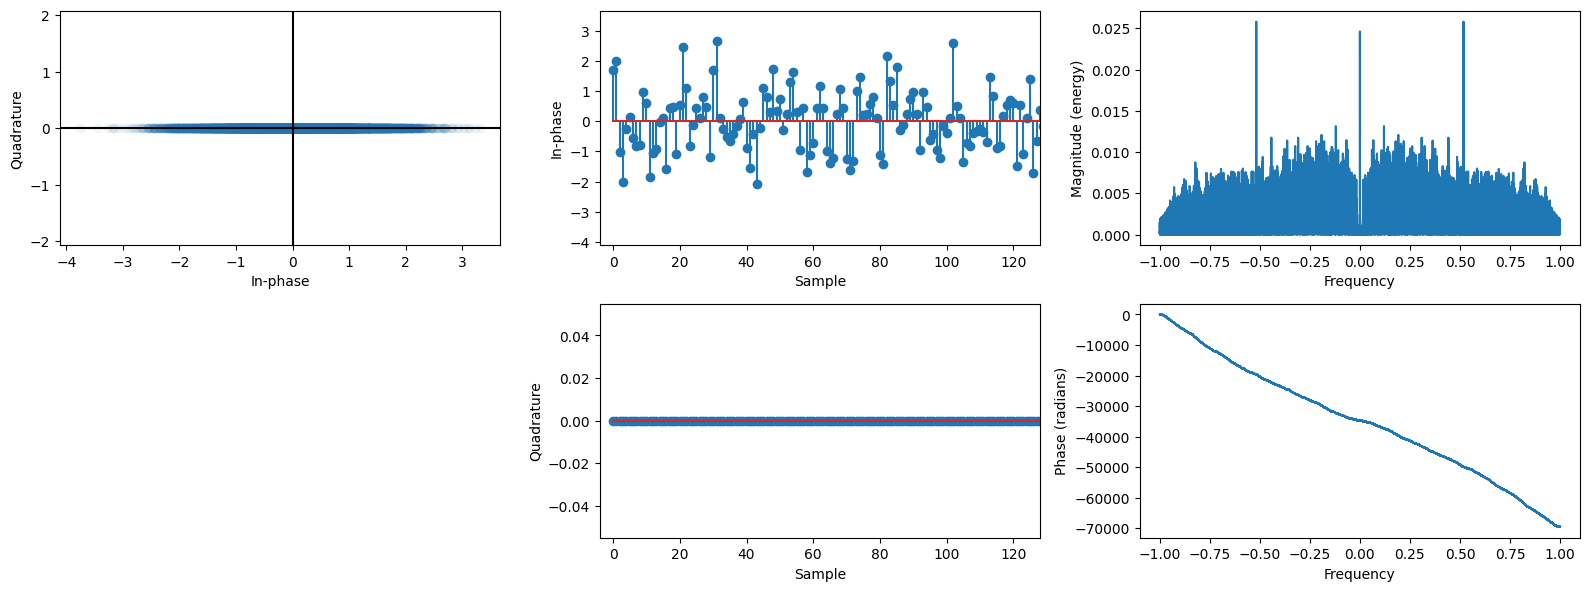

In [12]:
plot_signal(data_100)

In [13]:
# Peak in the spectrum is the IF
np.fft.fftfreq(data_100.size, d=1/100e9)[np.argmax(np.fft.fft(data_100))] / 1e9

-25.88703924305985

In [14]:
# XXX the IF has to be negative for some reason (the spectrum is mirrored)
rx_if = Digital90degHybrid(-25.887, 100e9)(data_100)

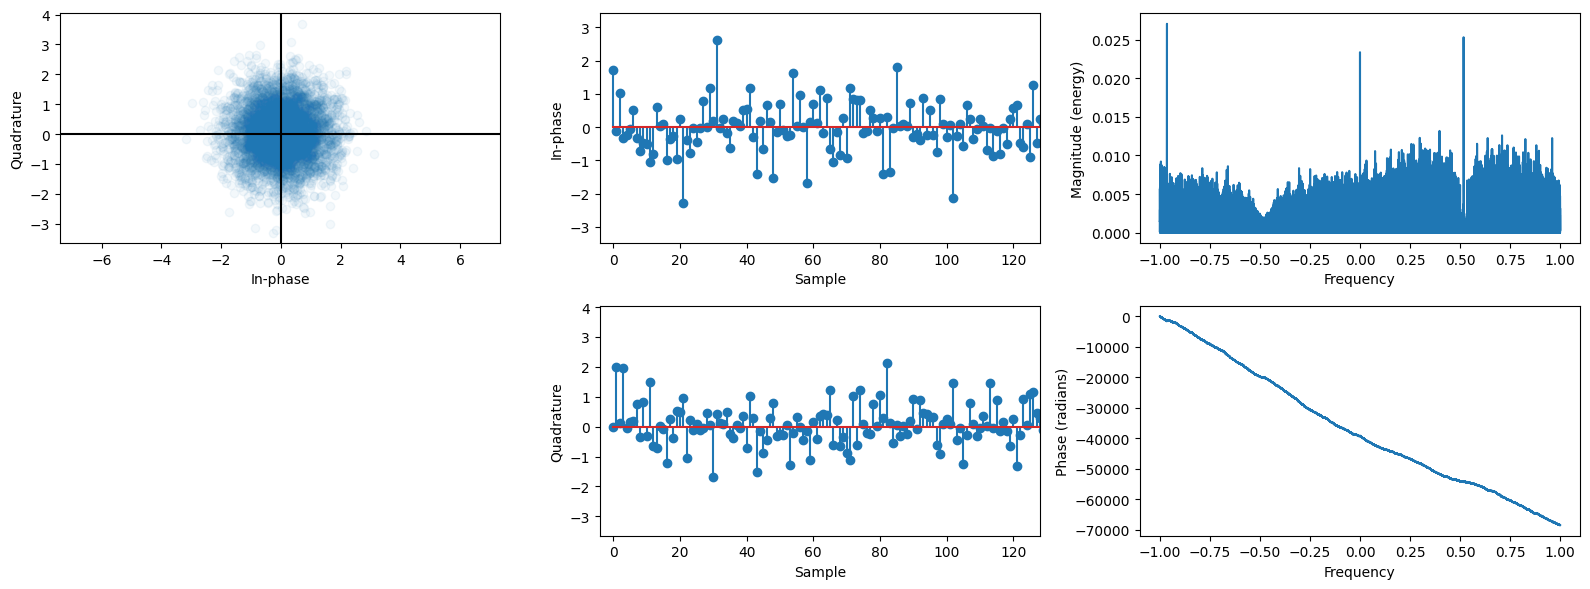

In [15]:
plot_signal(rx_if)

In [16]:
# 25 km of fibre.
# rx_cd = CDCompensator(25_000, 100e9, 2, 35, 0.01)(rx_if)

In [17]:
# plot_signal(rx_cd)

In [18]:
pf = PulseFilter(2, down=1)
pf.BETA = 0.01
pf.SPAN = 508
# rx_pf = pf(rx_cd) # XXX without frequency recovery
rx_pf = pf(rx_if) # XXX without frequency recovery

In [19]:
assert pf.impulse_response.size == 1016

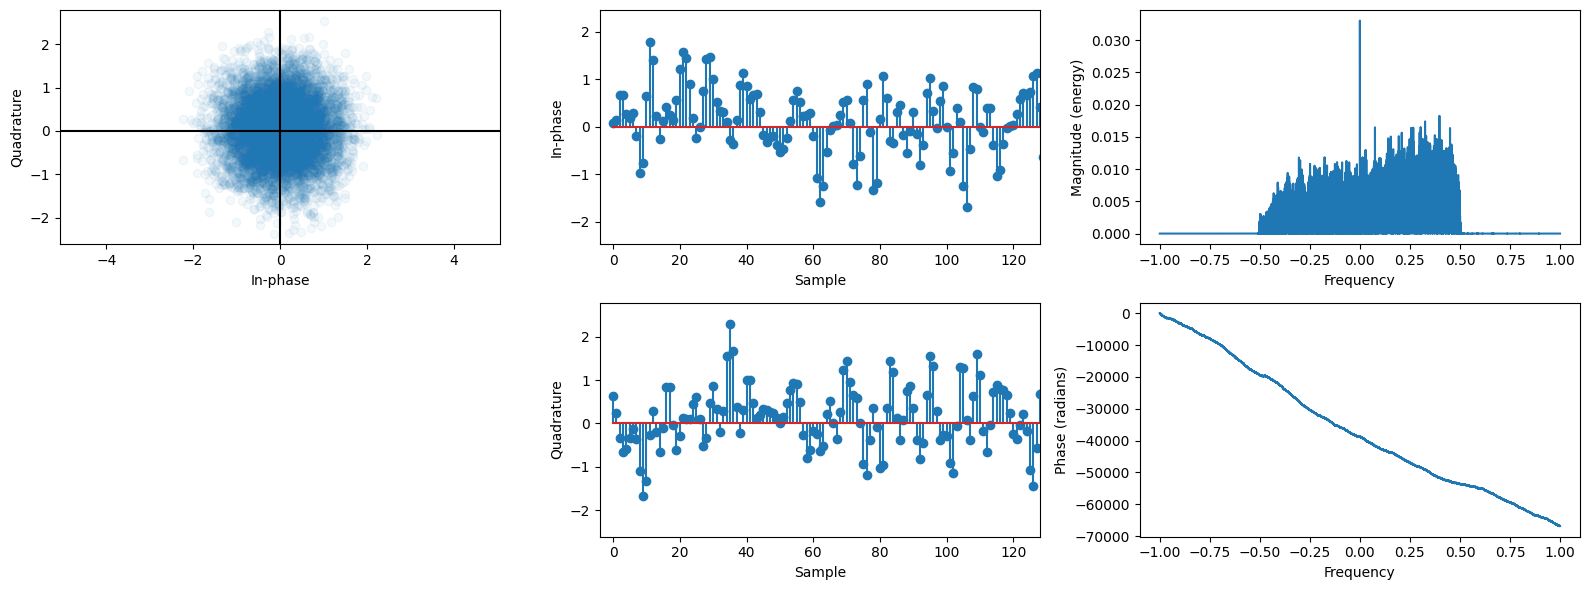

In [20]:
plot_signal(rx_pf)

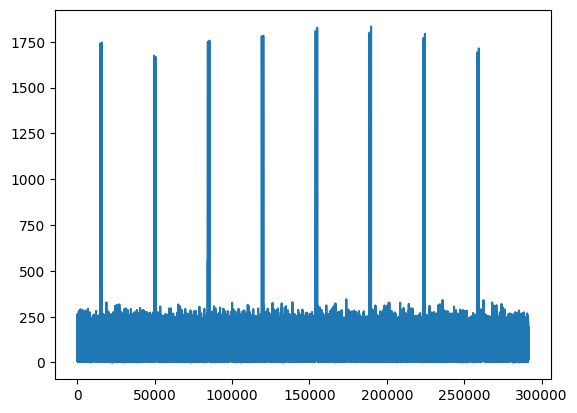

In [21]:
plt.plot(np.abs(np.correlate(rx_pf[::2], qpsk_sync)));

In [22]:
def find_lag(ref: np.ndarray, sig: np.ndarray) -> int:
    corr = np.abs(signal.correlate(ref, sig))
    lags = signal.correlation_lags(ref.size, sig.size)
    plt.plot(lags, corr)
    plt.show()
    lag = lags[np.argmax(corr)]
    return lag

In [23]:
def find_all_lags(ref: np.ndarray, sig: np.ndarray, threshold: float) -> int:
    corr = np.abs(signal.correlate(ref, sig))
    lags = signal.correlation_lags(ref.size, sig.size)
    lag = lags[corr > threshold]
    return lag

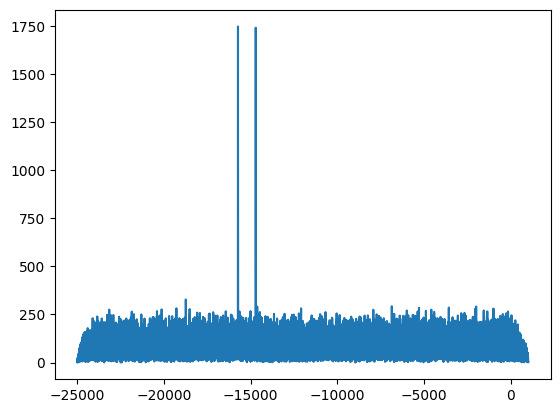

-15731

In [24]:
find_lag(qpsk_sync, rx_pf[0:50_000:2])

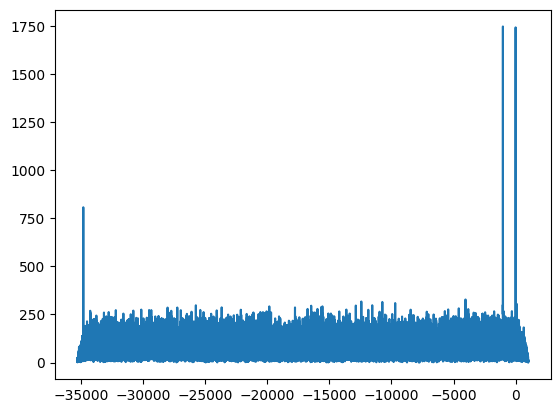

-1023

In [25]:
# qpsk_sync leads rx_pf by 14708 samples
find_lag(qpsk_sync, rx_pf[2*14708:2*50_000:2])

In [26]:
all_lags = find_all_lags(qpsk_sync, rx_pf[::2], 500)
all_lags

array([-259445, -259444, -259443, -259442, -259441, -259440, -259439,
       -258421, -258420, -258419, -258418, -258417, -258416, -258415,
       -224630, -224629, -224628, -224627, -224626, -224625, -224624,
       -224623, -223607, -223606, -223605, -223604, -223603, -223602,
       -223601, -223600, -223599, -189815, -189814, -189813, -189812,
       -189811, -189810, -189809, -189808, -189807, -188791, -188790,
       -188789, -188788, -188787, -188786, -188785, -188784, -188783,
       -154999, -154998, -154997, -154996, -154995, -154994, -154993,
       -154992, -154991, -153975, -153974, -153973, -153972, -153971,
       -153970, -153969, -153968, -153967, -120183, -120182, -120181,
       -120180, -120179, -120178, -120177, -120176, -119159, -119158,
       -119157, -119156, -119155, -119154, -119153, -119152,  -85367,
        -85366,  -85365,  -85364,  -85363,  -85362,  -85361,  -85360,
        -84343,  -84342,  -84341,  -84340,  -84339,  -84338,  -84337,
        -84336,  -50

In [27]:
np.diff(all_lags)

array([    1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,  1017,     1,     1,     1,     1,     1,     1,
           1, 33785,     1,     1,     1,     1,     1,     1,     1,
        1017,     1,     1,     1,     1,     1,     1,     1, 33786,
           1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1017,     1,     1,     1,     1,     1,
           1,     1]

In [28]:
rx_sync = rx_pf[2 * 14708:-3]
rx_sync.shape

(555504,)

In [29]:
np.diff(find_all_lags(qpsk_sync, rx_sync[::2], 500))

array([    1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,     1,  1016,     1,     1,     1,     1,     1,
           1,     1,     1, 33784,     1,     1,     1,     1,     1,
           1,     1,  1017,     1,     1,     1,     1,     1,     1,
           1, 33785,     1,     1,     1,     1,     1,     1,     1,
        1017,     1,     1,     1,     1,     1,     1,     1, 33786,
           1,     1,     1,     1,     1,     1,  1018,     1,     1,
           1,     1,     1,     1, 33785,     1,     1,     1,     1,
           1,     1,     1,  1017,     1,     1,     1,     1,     1,
           1,     1]

In [30]:
2 * qpsk_sync.size + data_ref.size

34816

In [31]:
rx_16qam = rx_sync[np.mod(np.arange(rx_sync.size), 2 * 34816) >= 2 * 2 * 1024]
rx_16qam.size

522736

In [32]:
training = np.tile(data_ref, 10)

In [33]:
aeq = AdaptiveEqualizerAlamouti(47, 6.5e-2, 6.1e-2, Modulator16QAM(), Demodulator16QAM(), training, True)
rx_aeq = aeq(rx_16qam)

In [34]:
# mus = []
# bers = []

# for mu in range(1, 200, 4):
#     aeq = AdaptiveEqualizerAlamouti(47, 6.5e-2, mu * 1e-3, Modulator16QAM(), Demodulator16QAM(), training, True)
#     rx_aeq = aeq(rx_16qam)

#     rx_demod = Demodulator16QAM()(rx_aeq)
    
#     mus.append(mu)
#     bers.append(np.sum(ref_demod[20_000:] ^ rx_demod[20_000:]) / ref_demod.size)

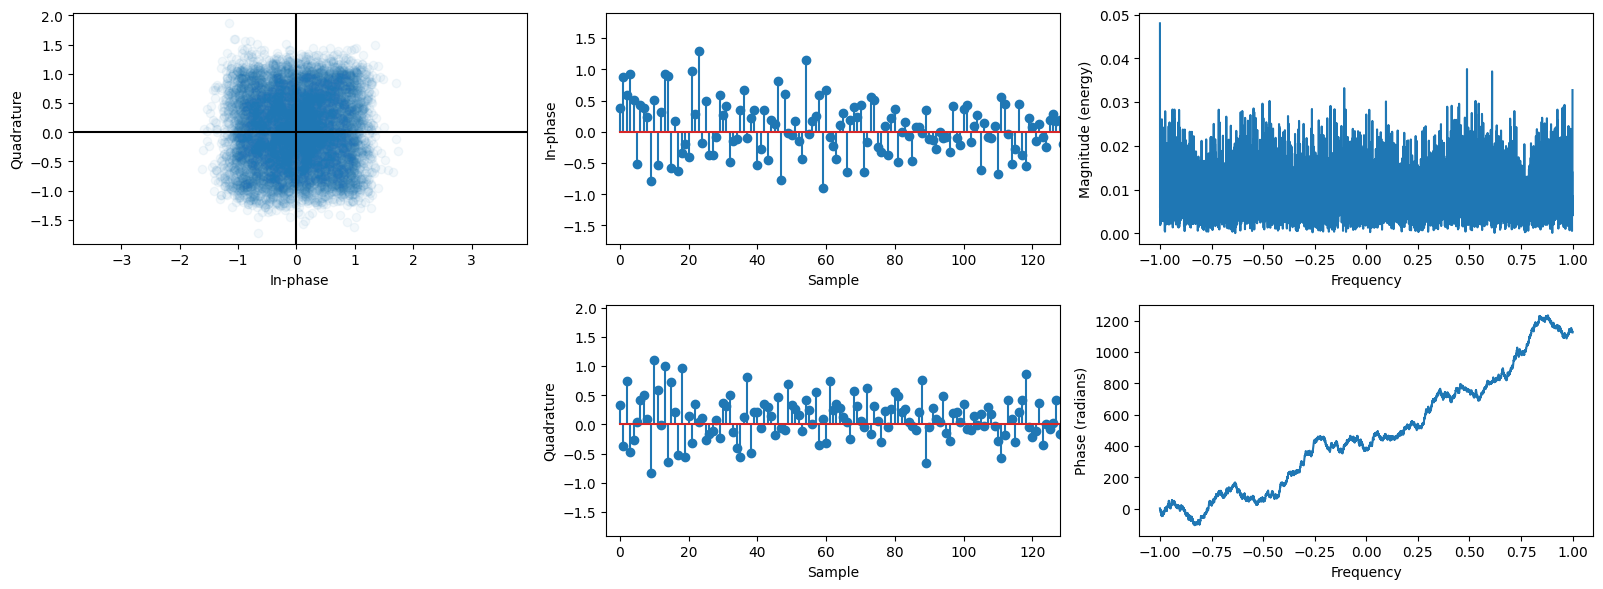

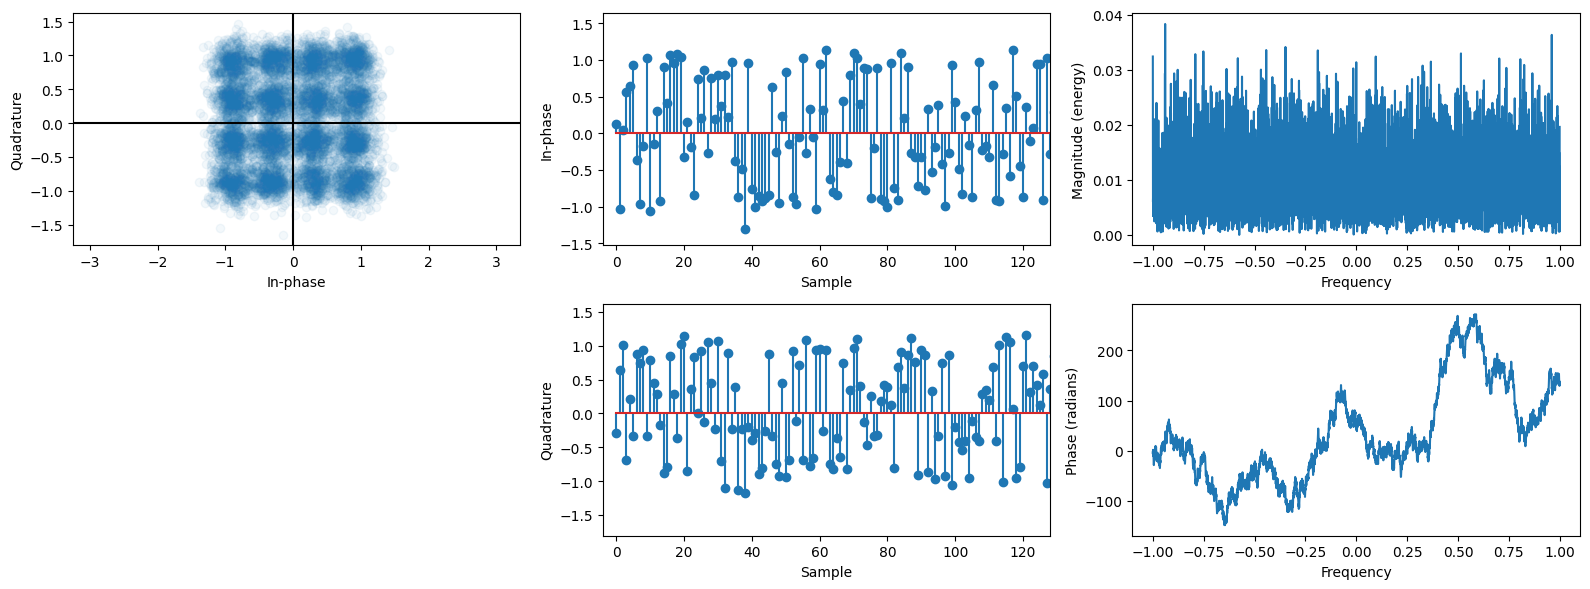

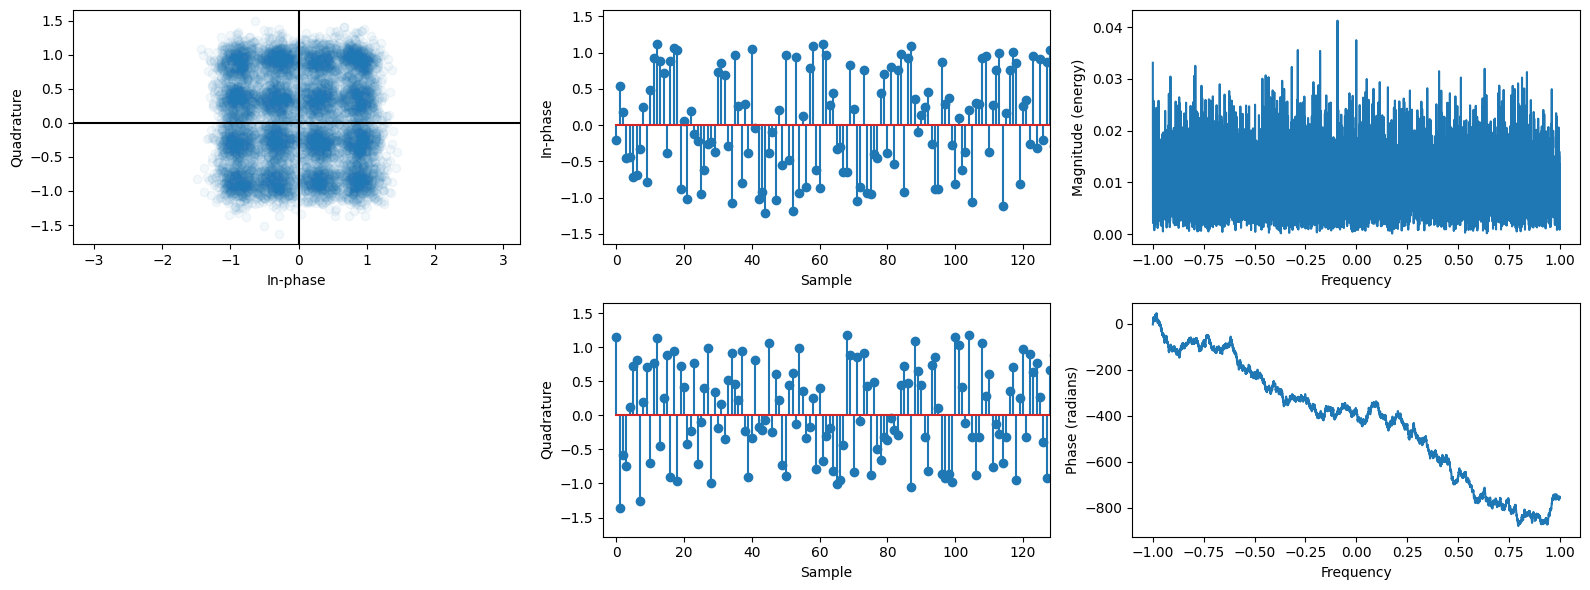

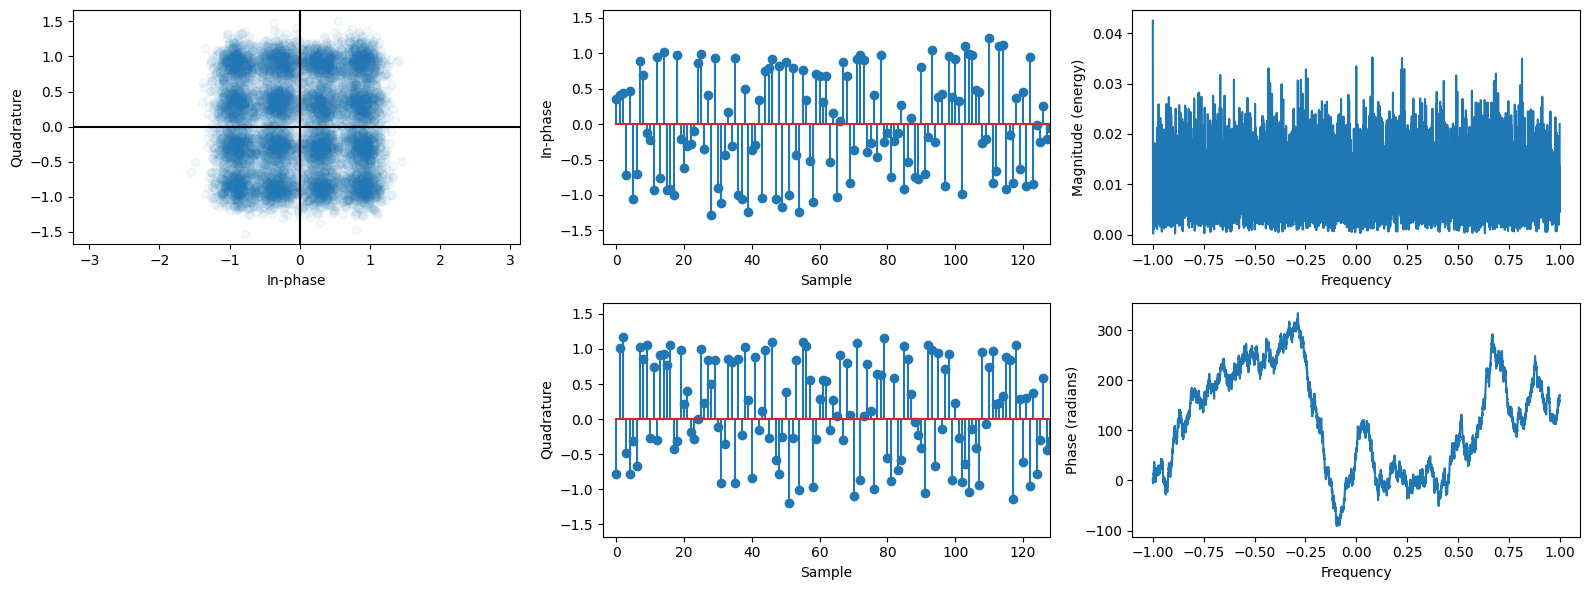

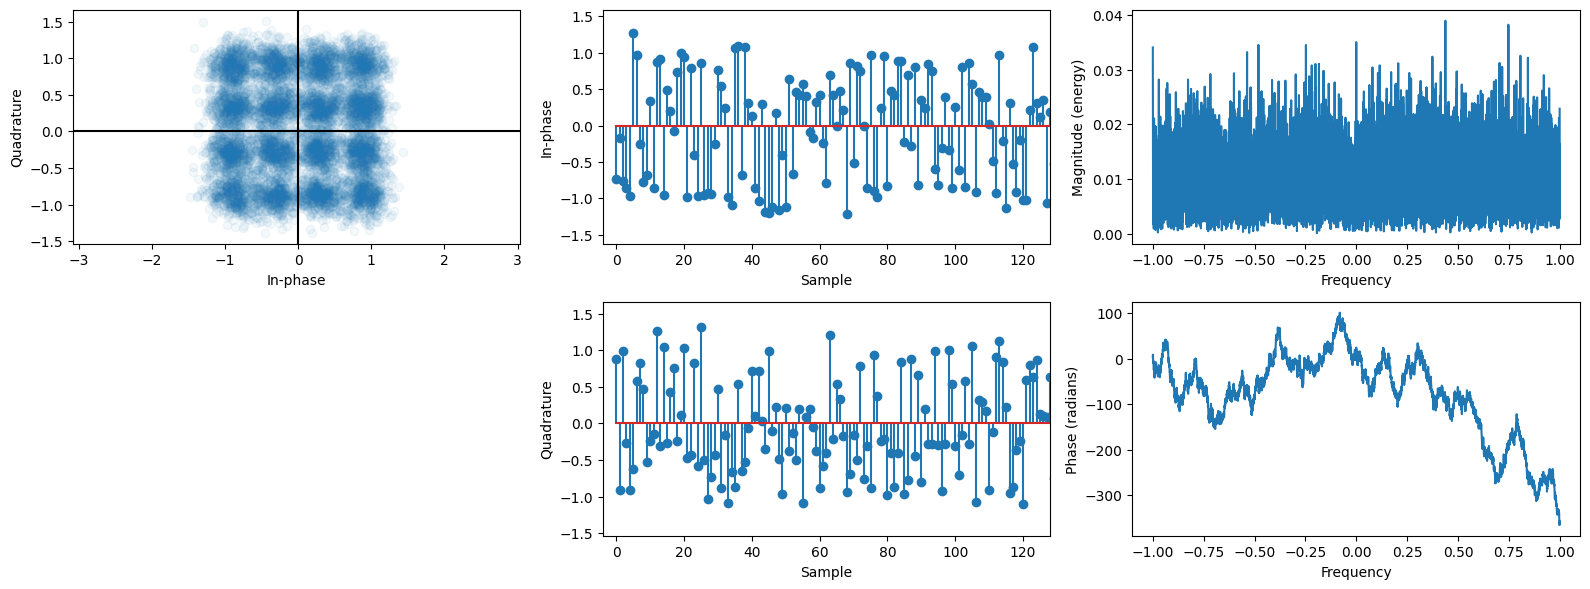

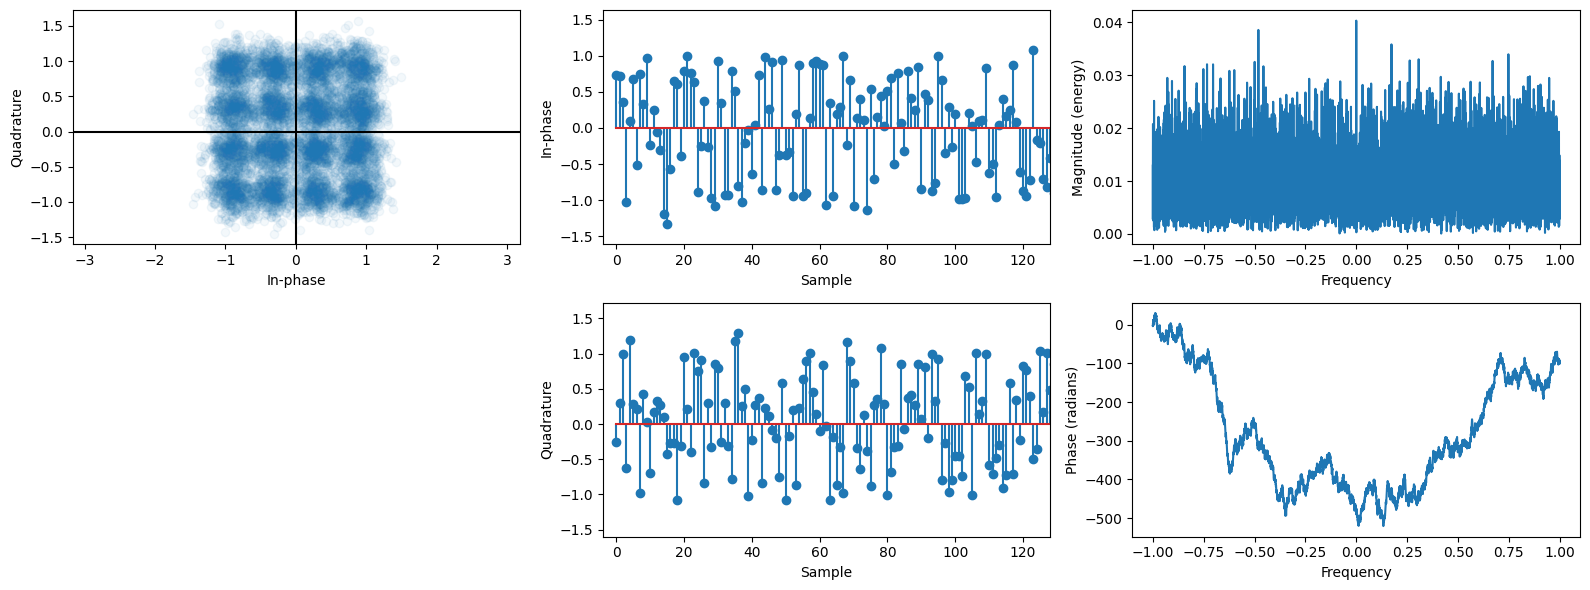

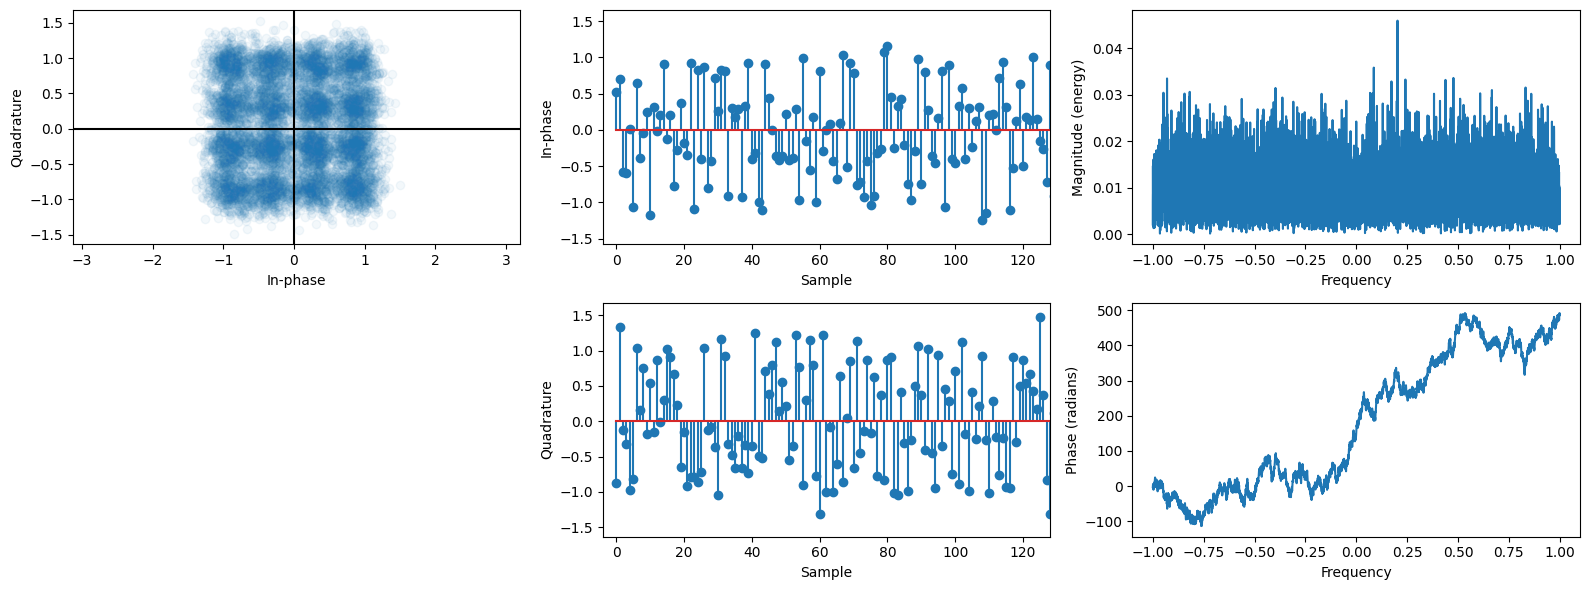

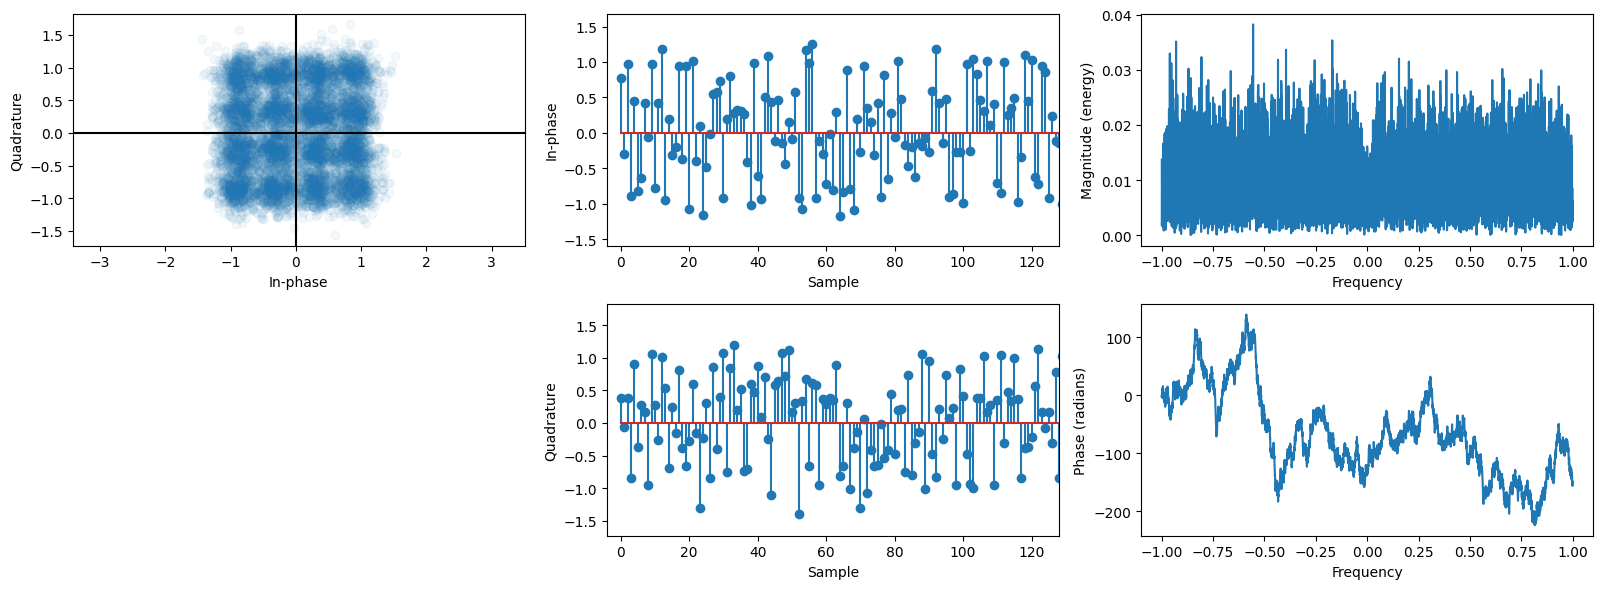

In [35]:
for i in range(8):
    plot_signal(rx_aeq[i * 30_000 : i * 30_000 + 10_000])

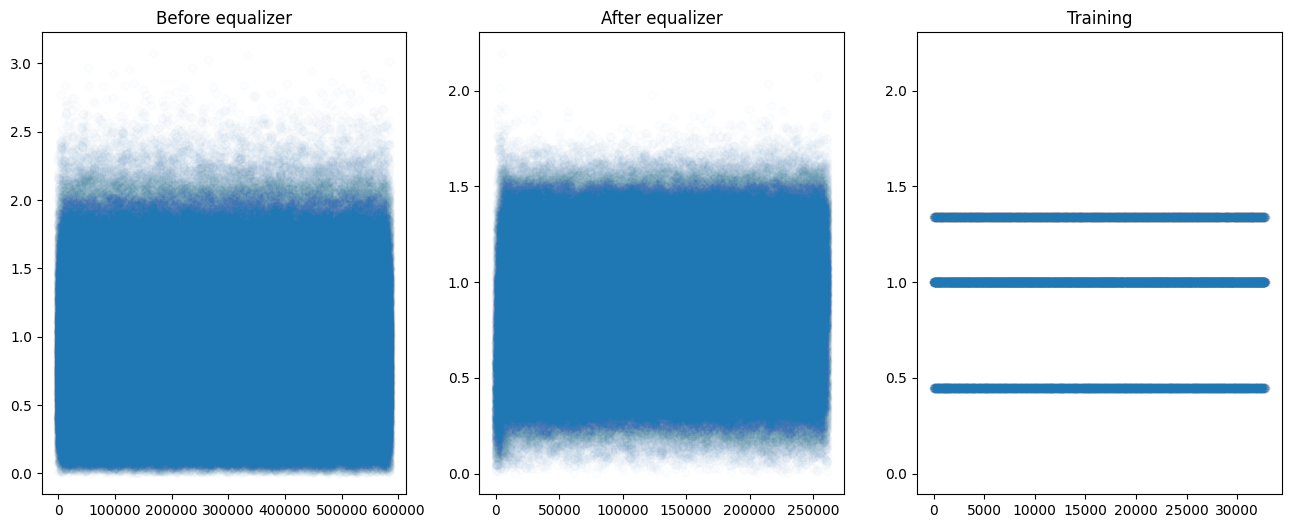

In [36]:
from utils import has_one_polarization, normalize_power

fig, axs = plt.subplots(1, 3, figsize=(16,6))
assert has_one_polarization(rx_pf)
axs[0].scatter(range(rx_pf.size), np.abs(normalize_power(rx_pf)), alpha=0.01)
axs[0].set_title("Before equalizer")
assert has_one_polarization(rx_aeq)
axs[1].scatter(range(rx_aeq.size), np.abs(rx_aeq), alpha=0.01)
axs[1].set_title("After equalizer")
# axs[1].set_ylim(0, 3)
assert has_one_polarization(data_ref)
axs[2].scatter(range(data_ref.size), np.abs(data_ref), alpha=0.01)
axs[2].set_title("Training")
axs[2].set_ylim(*axs[1].get_ylim())

plt.show()

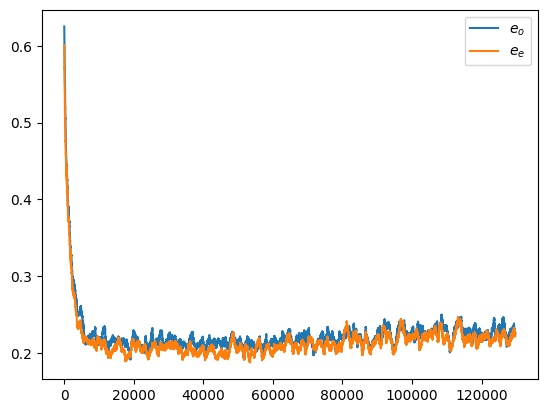

In [37]:
def ma(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(ma(np.abs(aeq.e_oC_log), 1_000), label="$e_o$")
plt.plot(ma(np.abs(aeq.e_eC_log), 1_000), label="$e_e$")
plt.legend()
plt.show()

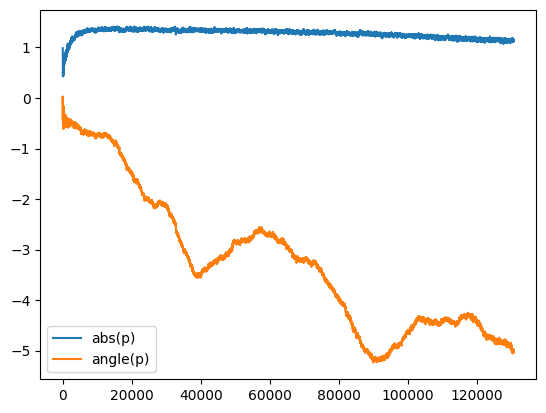

In [38]:
plt.plot(np.abs(aeq.p_log), label="abs(p)")
plt.plot(np.unwrap(np.angle(aeq.p_log)), label="angle(p)")
plt.legend()
plt.show()

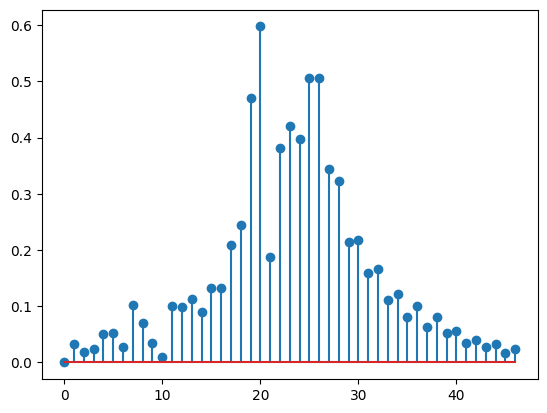

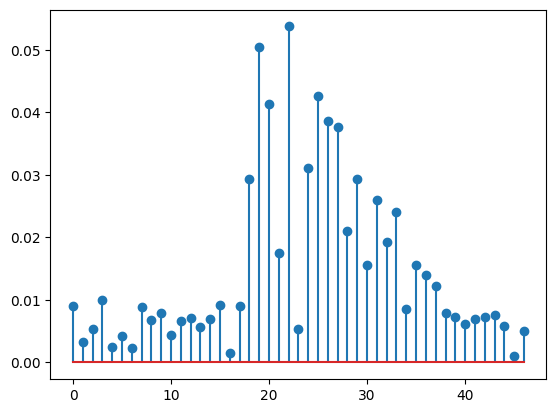

In [39]:
plt.stem(np.abs(aeq.w11))
plt.show()
plt.stem(np.abs(aeq.w12))
plt.show()

In [40]:
rx_demod = Demodulator16QAM()(rx_aeq)

In [41]:
from numpy.typing import NDArray


def compare_streams(
    ref: NDArray[np.bool_], sig: NDArray[np.bool_]
) -> tuple[float, float]:
    # Ensure lag + y.size < x.size.
    sig_slice = sig[:-10_000] if sig.size > ref.size - 10_000 else sig

    lag = find_lag(ref, sig_slice)
    assert lag >= 0

    ref_slice = ref[lag : lag + sig_slice.size]
    assert ref_slice.size == sig_slice.size

    ber = np.count_nonzero(ref_slice ^ sig_slice) / ref_slice.size

    return lag, ber

In [42]:
ref_demod = Demodulator16QAM()(np.tile(data_ref, 10))[:rx_demod.size]
# compare_streams(ref_demod, rx_demod)
# compare_streams(rx_demod, ref_demod)

In [43]:
np.sum(ref_demod[20_000:] ^ rx_demod[20_000:]) / ref_demod.size

0.02988793578402865